####     From this notebook we get:
        "Figure 10: Fuel consumption and emissions rates for deep water depth (6 m)".
####    General steps:
        -First we create and run the basic simulation of the ship sailing on the waterway.
        -Then we plot the figure based on the results of the fuel consumption and emissions rates from the basic simulation.
        

## Basic simulation - consumes energy-van Dosser actual draught & payload
We are going to make a simulation which forces a vessel to move over a certain 1D waterway network. It tries to give one an understanding of the most basic core functions of OpenTNSim and teach one the requirements to set-up a basic OpenTNSim model run. 

We add some properties to the graph (depth) and the vessel (VesselProperties, ConsumesEnergy) in order to calculate resistance, required power, 

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

import logging
#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).


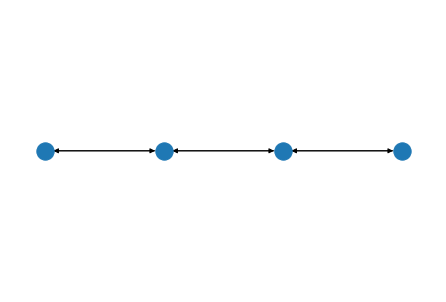

In [2]:
FG = nx.DiGraph()
nodes = []
path = []

Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

data_node_1 = {"name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"name": "Node 2",
               "geometry": shapely.geometry.Point(0.8983, 0)}  # 0.8983 degree =100km
data_node_3 = {"name": "Node 3",
               "geometry": shapely.geometry.Point(1.7966, 0)}   # 1.7966 degree =200km
data_node_4 = {"name": "Node 4",
               "geometry": shapely.geometry.Point(2.6949, 0)}    # 2.6949 degree =300km

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2], # From node 1 to node 2
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3], # From node 4 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_2, node_1]] # From node 2 to node 1

for edge in path:
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": 6})
    
middle_edges = [
    (node_2.name, node_3.name),
    (node_3.name, node_2.name)
]

for e in middle_edges:
    edge = FG.edges[e]
    edge['Info']['GeneralDepth'] = 6

# env.FG = FG
nx.draw(FG, positions)
plt.show()

In [3]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 1', 'Node 2') is 6
General depth for edge ('Node 2', 'Node 3') is 6
General depth for edge ('Node 2', 'Node 1') is 6
General depth for edge ('Node 3', 'Node 4') is 6
General depth for edge ('Node 3', 'Node 2') is 6
General depth for edge ('Node 4', 'Node 3') is 6


### Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption. 

In [4]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [5]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later

data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type":None,
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": 3.5,
               "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }             

vessel = TransportResource(**data_vessel)

In [6]:
vessel.P_hotel

87.5

### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [7]:
path = nx.dijkstra_path(FG, node_1.name, node_4.name)

### Run simulation
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [8]:
def run_simulation(V_s, P_tot_given):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel.P_tot_given = P_tot_given
    
    depths = []
    for e in zip(vessel.route[:-1], vessel.route[1:]):
        edge = env.FG.edges[e]
        depth = edge['Info']['GeneralDepth']
        depths.append(depth)
 
    
    for depth in depths:
            h_0 = depth
            if V_s is None:
                v_0 = opentnsim.energy.power2v(vessel, edge, bounds=(0, 10))
                h_0 = vessel.calculate_h_squat(v = v_0, h_0 = h_0)
            else:    
                h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
            print(h_0)    
    # Start the simulation
    env.process(vessel.move())
    env.run()

    return vessel

In [9]:
input_data = {'V_s': [3.0, 3.5, 4.0, None, None, None], 'P_tot_given': [None, None, None, 251, 343, 494]}
input_data

{'V_s': [3.0, 3.5, 4.0, None, None, None],
 'P_tot_given': [None, None, None, 251, 343, 494]}

In [10]:
# create empty plot data
plot_data = {}

# loop through the various input data
for index, value in enumerate(input_data['V_s']):
    #print("value", value)   
    # Run a basic simulation with V_s and P_tot_given combi

    vessel = run_simulation(input_data['V_s'][index], input_data['P_tot_given'][index])

    # create an EnergyCalculation object and perform energy consumption calculation
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    # create dataframe from energy calculation computation
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
    # add/modify some comlums to suit our plotting needs
   
    df['fuel_kg_per_km'] = (df['total_fuel_consumption']/1000) / (df['distance']/1000)
    df['CO2_g_per_km']   = (df['total_emission_CO2']) / (df['distance']/1000)
    df['PM10_g_per_km']  = (df['total_emission_PM10']) / (df['distance']/1000)
    df['NOx_g_per_km']   = (df['total_emission_NOX']) / (df['distance']/1000)
    
    label = 'V_s = ' + str(input_data['V_s'][index]) + ' P_tot_given = ' + str(input_data['P_tot_given'][index])

    # Note that we make a dict to collect all plot data. 
    # We use labels like ['V_s = None P_tot_given = 274 fuel_kg_km'] to organise the data in the dict
    # The [0, 0, 1, 1, 2, 2] below creates a list per section 
    plot_data[label + ' P_tot']   = list(df.P_tot[[0, 0, 1, 1, 2, 2]])
    plot_data[label + ' fuel_kg_per_km']   = list(df.fuel_kg_per_km[[0, 0, 1, 1, 2, 2]])
    plot_data[label + ' CO2_g_per_km'] = list(df.CO2_g_per_km[[0, 0, 1, 1, 2, 2]])
    plot_data[label + ' PM10_g_per_km']   = list(df.PM10_g_per_km[[0, 0, 1, 1, 2, 2]])
    plot_data[label + ' NOx_g_per_km']   = list(df.NOx_g_per_km[[0, 0, 1, 1, 2, 2]])
        

5.966530228090588
5.966530228090588
5.966530228090588
5.953878643172866
5.953878643172866
5.953878643172866
5.939112895037427
5.939112895037427
5.939112895037427
5.966476756526408
5.966476756526408
5.966476756526408
5.953871739388855
5.953871739388855
5.953871739388855
5.9389796934644155
5.9389796934644155
5.9389796934644155


C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWar

In [11]:
# this is now in the plot data
plot_data

{'V_s = 3.0 P_tot_given = None P_tot': [250.73956773396563,
  250.73956773396563,
  250.73956773396563,
  250.73956773396563,
  250.73956773396577,
  250.73956773396577],
 'V_s = 3.0 P_tot_given = None fuel_kg_per_km': [6.047631109715368,
  6.047631109715368,
  6.047631109715368,
  6.047631109715368,
  6.047631109715371,
  6.047631109715371],
 'V_s = 3.0 P_tot_given = None CO2_g_per_km': [19187.48415718785,
  19187.48415718785,
  19187.48415718785,
  19187.48415718785,
  19187.484157187857,
  19187.484157187857],
 'V_s = 3.0 P_tot_given = None PM10_g_per_km': [12.645312101988148,
  12.645312101988148,
  12.645312101988148,
  12.645312101988148,
  12.645312101988145,
  12.645312101988145],
 'V_s = 3.0 P_tot_given = None NOx_g_per_km': [279.7086541612337,
  279.7086541612337,
  279.7086541612337,
  279.7086541612337,
  279.7086541612337,
  279.7086541612337],
 'V_s = 3.5 P_tot_given = None P_tot': [343.2331930518234,
  343.2331930518234,
  343.2331930518234,
  343.2331930518234,
  343.23

## Figure 10
Fuel consumption (b) and emissions (c, d, e) of a fully loaded M8 ship sailing in the waterway with three speed levels relative to the water and corresponding required power levels: 3 m/s (251 kW), 3.5 m/s (343 kW), 4 m/s (494 kW). (a) represents the longisection of a 300 km long and 6 m deep waterway. M8 ship characteristics: engine construction year = 1990, installed engine power = 1750 kW, length =110 m, beam = 11.4 m, actual draught = 3.5 m, payload = 2700 ton.

The below results of fuel (diesel) consumption, emissions rates at different ship speeds and power used for Figure 10 are calculated from the above simulation by changing ship speed(or power) and water depth.

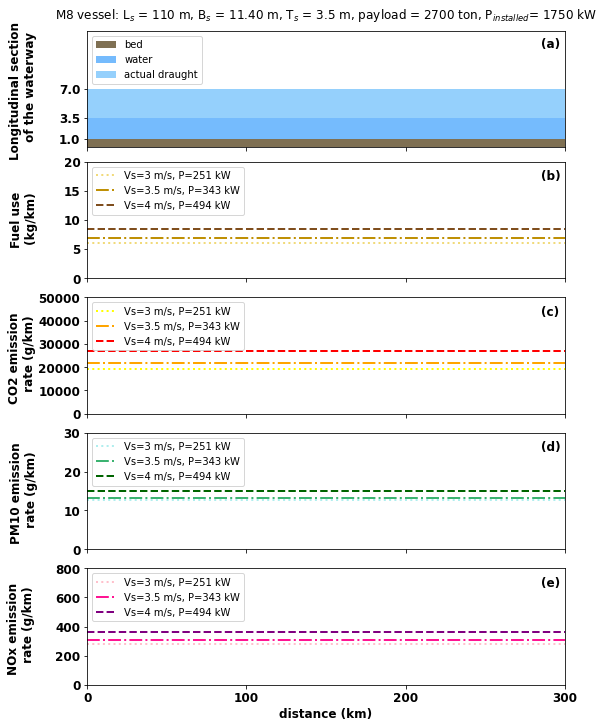

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(8, 10), sharex=True,constrained_layout=True)
fontsize=12

ax=plt.subplot(511)    # Longitudinal section of the waterway

# these values you probably want to extract from the graph, or from the log (minimise the manual work!!)
dist=[0,100,100,200,200,300]
water_level=[2.5,2.5,2.5,2.5,2.5,2.5,]
bed_level=[1,1,1,1,1,1]
draft=[3.5,3.5,3.5,3.5,3.5,3.5,]
plt.title('M8 vessel: L$_s$ = 110 m, B$_s$ = 11.40 m, T$_s$ = 3.5 m, payload = 2700 ton, P$_{installed}$= 1750 kW',y=1.05)
plt.stackplot(dist,bed_level,water_level,draft, labels=['bed','water','actual draught'],colors=['#7f7053','#75bbfd','#95d0fc'])
plt.ylabel('Longitudinal section \n of the waterway',fontsize=12,fontweight='bold',labelpad=22)
plt.xlim(0, 300)
plt.ylim(0, 14)
plt.xticks( weight = 'bold')
plt.yticks([1,3.5,7], weight = 'bold', fontsize=12)
ax.legend(loc='upper left')
ax.text(285, 12, '(a)', fontsize=12,weight = 'bold')

ax=plt.subplot(512)    #  fuel (diesel) consumption kg/km 

diesel_fv1=(plot_data['V_s = 3.0 P_tot_given = None fuel_kg_per_km']) # use values from the output_plot variable
diesel_fv2=(plot_data['V_s = 3.5 P_tot_given = None fuel_kg_per_km'])
diesel_fv3=(plot_data['V_s = 4.0 P_tot_given = None fuel_kg_per_km'])


plt.plot(dist, diesel_fv1,':',color='#f1da7a',linewidth='2',label='Vs=3 m/s, P=251 kW')
plt.plot(dist, diesel_fv2,'-.',color='#bf9005',linewidth='2',label='Vs=3.5 m/s, P=343 kW')
plt.plot(dist, diesel_fv3,'--',color='#7f4e1e',linewidth='2',label='Vs=4 m/s, P=494 kW')

plt.ylabel('Fuel use\n (kg/km)',fontsize=12,fontweight='bold',labelpad=26)
plt.ylim(0, 20)
plt.xlim(0, 300)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
ax.legend(loc='upper left')
ax.text(285, 20*11/13, '(b)', fontsize=12,weight = 'bold')

ax=plt.subplot(513)    #  CO2 emission rates g/km
ax.legend(loc='upper left')

EMrCO2_fv1=(plot_data['V_s = 3.0 P_tot_given = None CO2_g_per_km'])
EMrCO2_fv2=(plot_data['V_s = 3.5 P_tot_given = None CO2_g_per_km'])
EMrCO2_fv3=(plot_data['V_s = 4.0 P_tot_given = None CO2_g_per_km'])


plt.plot(dist, EMrCO2_fv1,':',color='yellow',linewidth='2',label='Vs=3 m/s, P=251 kW')
plt.plot(dist, EMrCO2_fv2,'-.',color='orange',linewidth='2',label='Vs=3.5 m/s, P=343 kW')
plt.plot(dist, EMrCO2_fv3,'--',color='red',linewidth='2',label='Vs=4 m/s, P=494 kW')

ax.legend(loc='upper left')
plt.ylabel('CO2 emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=2)
plt.ylim(0, 50000)
plt.xlim(0, 300)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
ax.text(285, 50000*11/13, '(c)', fontsize=12,weight = 'bold')

ax=plt.subplot(514)    #  PM10 emission rates g/km

EMrPM10_fv1=(plot_data['V_s = 3.0 P_tot_given = None PM10_g_per_km'])
EMrPM10_fv2=(plot_data['V_s = 3.5 P_tot_given = None PM10_g_per_km'])
EMrPM10_fv3=(plot_data['V_s = 4.0 P_tot_given = None PM10_g_per_km'])


plt.plot(dist, EMrPM10_fv1,':',color='paleturquoise',linewidth='2',label='Vs=3 m/s, P=251 kW')
plt.plot(dist, EMrPM10_fv2,'-.',color='mediumseagreen',linewidth='2',label='Vs=3.5 m/s, P=343 kW')
plt.plot(dist, EMrPM10_fv3,'--',color='darkgreen',linewidth='2',label='Vs=4 m/s, P=494 kW')

ax.legend(loc='upper left')
plt.ylabel('PM10 emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=26)
plt.ylim(0, 30)
plt.xlim(0, 300)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
ax.text(285, 30*11/13, '(d)', fontsize=12,weight = 'bold')

ax=plt.subplot(515)     #  NOx emission rates g/km

EMrNOx_fv1=(plot_data['V_s = 3.0 P_tot_given = None NOx_g_per_km'])
EMrNOx_fv2=(plot_data['V_s = 3.5 P_tot_given = None NOx_g_per_km'])
EMrNOx_fv3=(plot_data['V_s = 4.0 P_tot_given = None NOx_g_per_km'])


plt.plot(dist, EMrNOx_fv1,':',color='pink',linewidth='2',label='Vs=3 m/s, P=251 kW')
plt.plot(dist, EMrNOx_fv2,'-.',color='deeppink',linewidth='2',label='Vs=3.5 m/s, P=343 kW')
plt.plot(dist, EMrNOx_fv3,'--',color='purple',linewidth='2',label='Vs=4 m/s, P=494 kW')

plt.ylabel('NOx emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=20)
plt.xlabel('distance (km)',fontsize=12,fontweight='bold',labelpad=3)
plt.ylim(0, 800)
plt.xlim(0, 300)
ax.legend(loc='upper left')
plt.xticks([0,100,200,300], weight = 'bold', fontsize=12)
plt.yticks( weight = 'bold', fontsize=12)
ax.text(285, 800*11/13, '(e)', fontsize=12,weight = 'bold')

plt.savefig('Fig_10.pdf', bbox_inches = 'tight', dpi=600, format='pdf')  